<div class="jumbotron jumbotron-fluid">
  <div class="container">
    <h1 class="display-4">ROV underwater species detection</h1>
    <p class="lead">A short notebook introducing techniques and common challenges for underwater species detection
   </p>
  </div>
</div>

In [ ]:
# Download data folder
!curl -L -o data.zip https://www.dropbox.com/sh/4qsj9yvgd88nlx1/data.zip?dl=1

<div class="alert alert-info" role="alert">
    
### NOTE: Data folder should be at the same level as the notebooks provided. 
    
</div>

In [1]:
# Imports
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import numpy as np

<div class="alert alert-success" role="alert">
  <h3 class="display-4">OpenCV is a highly-optimised open-source computer vision library. It is built in C/C++ with binders for Python</h3> 
</div>

<div class="alert alert-info" role="alert">
    <h3 class="display-4">Play a video</h3>
</div>

In [26]:
video_file = "./Data/videos/TjarnoROV1-990813_3-1122.mov"
video = cv2.VideoCapture(video_file)
 
while True:
    (grabbed, frame) = video.read()
    
    if not grabbed:
        break
 
    cv2.imshow("output", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
     
cv2.destroyAllWindows()
video.release()

<div class="alert alert-info" role="alert">
    <h3 class="display-4">Detect a colour</h3>
</div>

In [27]:
video_file = "./Data/videos/TjarnoROV1-990813_3-1122.mov"
video = cv2.VideoCapture(video_file)
 
while True:
    (grabbed, frame) = video.read()
    
    if not grabbed:
        break
 
    blur = cv2.GaussianBlur(frame, (21, 21), 0)
    hsv = cv2.cvtColor(blur, cv2.COLOR_BGR2HSV)
 
    lower = np.array([0,120,70])
    upper = np.array([180,255,255])
    lower = np.array(lower, dtype="uint8")
    upper = np.array(upper, dtype="uint8")
    mask = cv2.inRange(hsv, lower, upper)
 
    output = cv2.bitwise_and(frame, hsv, mask=mask)
    cv2.imshow("output", output)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
cv2.destroyAllWindows()
video.release()

<div class="alert alert-info" role="alert">
    <h3 class="display-4">Problem 1: Distortion of colour between foreground and background objects</h3>
</div>


In [28]:
def clearImage(image):
    # Convert the image from BGR to gray
    dark_image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

    channels = cv2.split(image)

    # Get the maximum value of each channel
    # and get the dark channel of each image
    # record the maximum value of each channel
    a_max_dst = [ float("-inf") ]*len(channels)
    for idx in range(len(channels)):
        a_max_dst[idx] = channels[idx].max()

    dark_image = cv2.min(channels[0],cv2.min(channels[1],channels[2]))

    # Gaussian filtering the dark channel
    dark_image = cv2.GaussianBlur(dark_image,(25,25),0)

    image_t = (255.-0.95*dark_image)/255.
    image_t = cv2.max(image_t,0.5)

    # Calculate t(x) and get the clear image
    for idx in range(len(channels)):
        channels[idx] = cv2.max(cv2.add(cv2.subtract(channels[idx].astype(np.float32), int(a_max_dst[idx]))/image_t,
                                                        int(a_max_dst[idx])),0.0)/int(a_max_dst[idx])*255
        channels[idx] = channels[idx].astype(np.uint8)

    return cv2.merge(channels)

<div class="alert alert-success" role="alert">
    <h3 class="display-4">Let's see what that looks like now</h3>
</div>

In [29]:
video_file = "./Data/videos/TjarnoROV1-990813_3-1122.mov"
video = cv2.VideoCapture(video_file)
 
while True:
    (grabbed, frame) = video.read()
    
    if not grabbed:
        break
 
    cv2.imshow("before", frame)
    frame = clearImage(frame)    
     
    cv2.imshow("after", frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
 
cv2.destroyAllWindows()
video.release()

<div class="alert alert-info" role="alert">
    <h3 class="display-4">Problem 2: How do we draw contours that represent the objects we detect with a suitable mask?</h3>
</div>

In [32]:
# Reference in C++: 
# https://answers.opencv.org/question/26280/background-color-similar-to-object-color-how-isolate-it/
 
#video_file = "./Data/videos/TjarnoROV1-990813_3-1122.mov"
video_file = "./Data/videos/000114 TMBL-ROV 2000 Säckenrevet EJ numrerade band_1440.mp4"
video = cv2.VideoCapture(video_file)

blur_size = 20
grid_size = 500
 
while True:
    (grabbed, frame) = video.read()
    
    if frame is None: break
    
    # Reduce the size that we observe to reduce noise from corners of the frame
    origin = frame[100:500, 100:500]
    
    if not grabbed:
        break
        
    # Clean up our image
    new_img = clearImage(frame)
        
    new_img = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    
    new_img = cv2.split(frame)[2]
    
    # Cut to the most important segment
    new_img = new_img[100:500, 100:500]
    
    blur_size += (1 - blur_size % 2)
    
    blur = cv2.GaussianBlur(new_img, (blur_size, blur_size), 0)
      
    # equalise the histogram
    equal = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(5,5)).apply(blur)
    
    grid_size += (1 - grid_size % 2)
    
    # create a binary mask using an adaptive thresholding technique
    binimage = cv2.adaptiveThreshold(equal, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
                                     cv2.THRESH_BINARY, grid_size, -30)
    
    cv2.imshow("bin", binimage)
    
    contours, _ = cv2.findContours(binimage.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Cycle through contours and add area to array
    areas = []
    for c in contours:
        areas.append(cv2.contourArea(c))

    # Sort array of areas by size
    try:
        largest = np.argmax(areas)
    except:
        largest = None

    if largest is not None:
        fishMask = np.zeros(new_img.shape, dtype = np.uint8)
        # Choose our largest contour to be the object we wish to detect
        fishContours = contours[largest]
        cv2.polylines(origin,  [fishContours],  True,  (0, 0, 255),  2)
        # Draw these contours we detect
        cv2.drawContours(fishMask, contours, -1, 255, -1);
        #cv2.imshow("fish_mask", fishMask)
        
    cv2.imshow("fish_contour", origin)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
 
cv2.destroyAllWindows()
video.release()

<div class="alert alert-danger" role="alert">
    <h3 class="display-4">Problem 3: A binary mask is not sufficient if we want to detect multiple objects in a frame, so what can we do?</h3>
</div>

![](https://miro.medium.com/max/5856/1*Hz6t-tokG1niaUfmcysusw.jpeg)

<div class="alert alert-info" role="alert">
    <h4 class="display-4">First convert all the video frames into images so we can label them</h4>
</div>

In [17]:
### Save frames as images
import cv2
import numpy as np
import scipy.io as sio
 
video_file = "./Data/videos/TjarnoROV1-990813_3-1122.mov"
video = cv2.VideoCapture(video_file)

total_frames = video.get(cv2.CAP_PROP_FRAME_COUNT)

frame_id = 0
i = 0
while True:
    (grabbed, frame) = video.read()
    
    if not grabbed:
        break
 
    new_img = clearImage(frame)
    new_img = cv2.resize(new_img, (416, 416))
    assert(new_img.shape == (416, 416, 3))
    
    adict = {}
    adict['img'] = new_img
    
    frame_id += 1
    
    if frame_id % 100 == 0:
        print("Saved", frame_id)
        cv2.imwrite("./Data/img/odf_video_frames/{:s}".format(str(i)+'.jpg'), new_img) 
        #sio.savemat("./img/POTSDAM/imgs/{:s}".format(str(i)+'.mat'), adict)
        i += 1
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
print('Saved images')
cv2.destroyAllWindows()
video.release()

Saved 100
Saved 200


KeyboardInterrupt: 

<div class="alert alert-info" role="alert">
    <h3 class="display-4">YOLO V3</h3>
</div>

![](https://miro.medium.com/max/1200/0*3A8U0Hm5IKmRa6hu.png)

<div class="alert alert-info" role="alert">
    <h4 class="display-4">Train test split</h4>
</div>

In [19]:
import glob, os

dataset_path = "./Data/img/odf_video_frames"

# Percentage of images to be used for the test set
percentage_test = 10;

# Create and/or truncate train.txt and test.txt
file_train = open('./Data/img/train.txt', 'w')  
file_test = open('./Data/img/test.txt', 'w')

# Populate train.txt and test.txt
counter = 1
index_test = int(percentage_test / 100 * len(os.listdir(dataset_path)))
for pathAndFilename in glob.iglob(os.path.join(dataset_path, "*.jpg")):  
    title, ext = os.path.splitext(os.path.basename(pathAndFilename))

    if counter == index_test+1:
        counter = 1
        file_test.write(os.path.basename(title) + '.jpg' + "\n")
    else:
        file_train.write(os.path.basename(title) + '.jpg' + "\n")
        counter = counter + 1

<div class="alert alert-info" role="alert">
    <h3 class="display-4">Annotation!</h3>
</div>

In [ ]:
#!pip install labelimg

In [ ]:
!labelImg ./Data/img/odf_video_frames/ ./Data/img/odf_classes.txt

<div class="alert alert-success" role="alert">
    <h2 class="display-4">Now, to the cloud for training...</h2>
</div>

[Google Colab Workbook](https://colab.research.google.com/drive/1lZmojs-vsarIiSoicY1QKcpB1Bp0Co3O)

![](https://media1.tenor.com/images/79e142098ed62e0486d81028283660b7/tenor.gif?itemid=12081780)

<div class="alert alert-info" role="alert">
    <h2 class="display-4">Model Evaluation</h2>
</div>

Retrieving data and plotting training loss graph...
Done! Plot saved as training_loss_plot.png


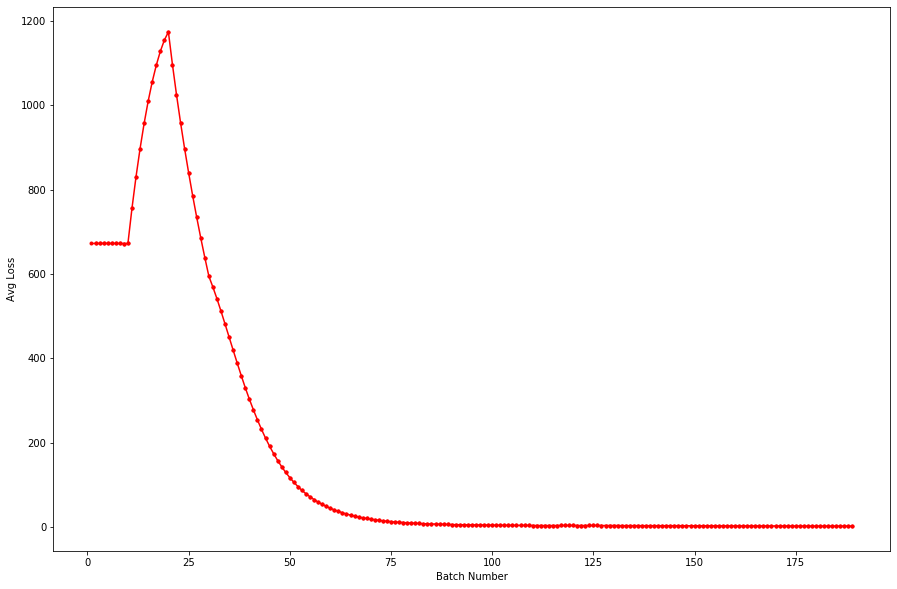

In [21]:
lines = []
for line in open('./Data/logs/train_log_example.log'):
    if "avg" in line:
        lines.append(line)

iterations = []
avg_loss = []

print('Retrieving data and plotting training loss graph...')
for i in range(len(lines)):
    lineParts = lines[i].split(',')
    iterations.append(int(lineParts[0].split(':')[0]))
    avg_loss.append(float(lineParts[1].split()[0]))

fig = plt.figure(figsize=(15,10))
for i in range(0, len(lines)):
    plt.plot(iterations[i:i+2], avg_loss[i:i+2], 'r.-')

plt.xlabel('Batch Number')
plt.ylabel('Avg Loss')
fig.savefig('training_loss_plot.png', dpi=1000)

print('Done! Plot saved as training_loss_plot.png')

In [33]:
## Visualize predictions using OpenCV

import cv2 as cv
import argparse
import sys
import numpy as np
import os.path

# Initialize the parameters
confThreshold = 0.1 #Confidence threshold
nmsThreshold = 0.4 #Non-maximum suppression threshold

inpWidth = 416  #608     #Width of network's input image
inpHeight = 416 #608     #Height of network's input image
        
# Load names of classes
classesFile = "./Data/models/sweden_yolo/odf_classes.names";

classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')

# Give the configuration and weight files for the model and load the network using them.

modelConfiguration = "./Data/models/sweden_yolo/sweden_yolo.cfg";
modelWeights = "./Data/models/sweden_yolo/sweden_yolo.backup";

net = cv.dnn.readNetFromDarknet(modelConfiguration, modelWeights)
net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv.dnn.DNN_TARGET_CPU)

# Get the names of the output layers
def getOutputsNames(net):
    # Get the names of all the layers in the network
    layersNames = net.getLayerNames()
    # Get the names of the output layers, i.e. the layers with unconnected outputs
    return [layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()]

# Draw the predicted bounding box
def drawPred(classId, conf, left, top, right, bottom):
    # Draw a bounding box.
    cv.rectangle(frame, (left, top), (right, bottom), (0, 255, 0), 3)

    label = '%.2f' % conf
        
    # Get the label for the class name and its confidence
    if classes:
        assert(classId < len(classes))
        label = '%s:%s' % (classes[classId], label)

    #Display the label at the top of the bounding box
    labelSize, baseLine = cv.getTextSize(label, cv.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    cv.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine), 
                 (0, 0, 255), cv.FILLED)
    
    cv.putText(frame, label, (left, top), cv.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 2)

# Remove the bounding boxes with low confidence using non-maxima suppression
def postprocess(frame, outs):
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]

    classIds = []
    confidences = []
    boxes = []
    # Scan through all the bounding boxes output from the network and keep only the
    # ones with high confidence scores. Assign the box's class label as the class with the highest score.
    classIds = []
    confidences = []
    boxes = []
    for out in outs:
        print("out.shape : ", out.shape)
        for detection in out:
            #if detection[4]>0.001:
            scores = detection[5:]
            classId = np.argmax(scores)
            #if scores[classId]>confThreshold:
            confidence = scores[classId]
            if detection[4]>confThreshold:
                print(detection[4], " - ", scores[classId], " - th : ", confThreshold)
                print(detection)
            if confidence > confThreshold:
                center_x = int(detection[0] * frameWidth)
                center_y = int(detection[1] * frameHeight)
                width = int(detection[2] * frameWidth)
                height = int(detection[3] * frameHeight)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                classIds.append(classId)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])

    # Perform non maximum suppression to eliminate redundant overlapping boxes with
    # lower confidences.
    indices = cv.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
    for i in indices:
        i = i[0]
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        drawPred(classIds[i], confidences[i], left, top, left + width, top + height)

# Process inputs
winName = 'ODF - Sweden Demo'
cv.namedWindow(winName, cv.WINDOW_NORMAL)

outputFile = "./Data/models/sweden_yolo/yolo_out_py.avi"

video_path = "./Data/models/sweden_yolo/crabs.mov"
cap = cv.VideoCapture(video_path)
vid_writer = cv.VideoWriter(outputFile, cv.VideoWriter_fourcc('M','J','P','G'),
                            30, (round(cap.get(cv.CAP_PROP_FRAME_WIDTH)),round(cap.get(cv.CAP_PROP_FRAME_HEIGHT))))


count = 0
    
while cv.waitKey(1) < 0:
    
    # get frame from the video
    hasFrame, frame = cap.read()
    if frame is None: break
    #frame = frame[100:516, 100:516]
    frame = clearImage(frame)
    frame = cv.resize(frame, (inpWidth, inpHeight))
    
    # Stop the program if reached end of video
    if not hasFrame:
        print("Done processing !!!")
        print("Output file is stored as ", outputFile)
        cv.waitKey(3000)
        break

    # Create a 4D blob from a frame.
    blob = cv.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)
    
    # Sets the input to the network
    net.setInput(blob)

    # Runs the forward pass to get output of the output layers
    outs = net.forward(getOutputsNames(net))

    # Remove the bounding boxes with low confidence
    postprocess(frame, outs)

    # Put efficiency information. The function getPerfProfile returns the overall time for inference(t) and the timings for each of the layers(in layersTimes)
    t, _ = net.getPerfProfile()
    label = 'Inference time: %.2f ms' % (t * 1000.0 / cv.getTickFrequency())
    vid_writer.write(frame.astype(np.uint8))
    
    count += 30 # i.e. at 30 fps, this advances one second
    cap.set(1, count)
    cv.imshow(winName, frame)
    

out.shape :  (507, 12)
out.shape :  (2028, 12)
0.99338716  -  0.9927307  - th :  0.1
[0.34093684 0.70253015 0.19548485 0.09305491 0.99338716 0.
 0.9927307  0.         0.         0.         0.         0.        ]
0.4184933  -  0.0  - th :  0.1
[0.34694046 0.6978515  0.11481451 0.11675186 0.4184933  0.
 0.         0.         0.         0.         0.         0.        ]
0.2840854  -  0.0  - th :  0.1
[0.5646592  0.72601837 0.08777602 0.1275598  0.2840854  0.
 0.         0.         0.         0.         0.         0.        ]
0.35381454  -  0.3387403  - th :  0.1
[0.5671127  0.7340139  0.09473849 0.15343133 0.35381454 0.
 0.         0.3387403  0.         0.         0.         0.        ]
0.23879912  -  0.0  - th :  0.1
[0.5591234  0.7370816  0.15437259 0.16596875 0.23879912 0.
 0.         0.         0.         0.         0.         0.        ]
out.shape :  (8112, 12)
0.30189627  -  0.30103755  - th :  0.1
[0.4270748  0.312449   0.06196008 0.06023816 0.30189627 0.
 0.         0.30103755 0. 